Given a sample

In [ ]:
# Gỡ cài đặt các phiên bản có thể gây xung đột để làm sạch môi trường
!pip uninstall -y numpy pandas scikit-learn hazm

# Cài đặt lại các thư viện theo đúng thứ tự, bắt đầu với numpy
!pip install numpy
!pip install pandas scikit-learn
!pip install -q hazm evaluate

In [1]:
import json
import time
import pandas as pd
from openai import OpenAI
from tqdm import tqdm
import numpy as np

# Import TẤT CẢ các mẫu prompt từ file prompt.py
from prompt import *

In [ ]:
# !!! QUAN TRỌNG: Hãy điền API Key của bạn vào đây
api_key = "..."  # Thay thế bằng API Key của bạn

# 1. Khởi tạo Client với API Key
client = OpenAI(api_key=api_key)

# 2. Định nghĩa các model và các kịch bản prompt
MODELS_TO_COMPARE = ["gpt-3.5-turbo", "gpt-4o-mini"]
PROMPTS_TO_TEST = {
    "English Prompt (Zero-shot)": ENGLISH_ZERO,
    "English Prompt (1-shot)": ENGLISH_ONE,
    "English Prompt (3-shot)": ENGLISH_THREE,
    "Persian Prompt (Zero-shot)": PERSIAN_ZERO,
    "Persian Prompt (1-shot)": PERSIAN_ONE,
    "Persian Prompt (3-shot)": PERSIAN_THREE,
}

# 3. Tải toàn bộ dữ liệu từ file RC.jsonl
try:
    full_data = []
    with open('RC.jsonl', 'r', encoding='utf-8') as reader:
        for line in reader:
            full_data.append(json.loads(line))
    
    # === Lấy 10 mẫu để kiểm tra ===
    SAMPLE_SIZE = 200
    all_data = full_data[:SAMPLE_SIZE] 
    
    print(f" Đã tải thành công {len(full_data)} cặp văn bản-câu hỏi.")
    print(f" sử dụng {len(all_data)} mẫu để kiểm tra.")

except FileNotFoundError:
    print(" Lỗi: Không tìm thấy file 'RC.jsonl'.")

 Đã tải thành công 200 cặp văn bản-câu hỏi.
 sử dụng 200 mẫu để kiểm tra.


In [3]:
from hazm import Normalizer

def get_answer_from_model(prompt, model_name):
    """
    Hàm này nhận một prompt và tên model, sau đó trả về câu trả lời.
    """
    try:
        response = client.chat.completions.create(
          model=model_name,
          messages=[
                {"role": "system", "content": "You are a helpful assistant. Answer the question based on the provided context."},
                {"role": "user", "content": prompt}
            ],
          temperature=0,
          max_tokens=256
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"\nLỗi khi gọi model {model_name}: {e}")
        return "ERROR"

In [4]:
def preprocess_text(s, normalizer):
    def normalize(text):
        text = text.replace("پاسخ:","")
        return normalizer.normalize(text)

    def remove_punc_stopword(text):
        exclude = ["?",".","!","؟",":","،",")","(","..."]
        return "".join(ch for ch in text if ch not in exclude)
    
    return normalize(remove_punc_stopword(s))

In [5]:
def compute_exact_match(prediction, truth, normalizer):
    # Đã tích hợp normalizer vào hàm
    return int(preprocess_text(prediction, normalizer) == preprocess_text(truth, normalizer))

In [6]:
def compute_f1(prediction, truth):
    pred_tokens = prediction.split()
    truth_tokens = truth.split()

    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)

    common_tokens = set(pred_tokens) & set(truth_tokens)

    if len(common_tokens) == 0:
        return 0

    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)

    return 2 * (prec * rec) / (prec + rec)

In [7]:
# Dictionary để lưu kết quả cuối cùng
final_results = {}

# Bắt đầu vòng lặp lớn
for model_name in MODELS_TO_COMPARE:
    print(f"============== BẮT ĐẦU MODEL: {model_name} ==============")
    final_results[model_name] = {}
    
    # Vòng lặp bên trong: chạy qua từng loại prompt
    for prompt_name, prompt_template in PROMPTS_TO_TEST.items():
        print(f"--- Đang chạy kịch bản: {prompt_name} ---")
        
        model_predictions = []
        
        # Chạy qua toàn bộ dữ liệu mẫu
        for sample in tqdm(all_data, desc=f"Querying {prompt_name}"):
            prompt = prompt_template.format(context=sample['context'], question=sample['question'])
            answer = get_answer_from_model(prompt, model_name)
            model_predictions.append(answer)
            time.sleep(1)

        # Lưu lại danh sách các câu trả lời của model
        final_results[model_name][prompt_name] = model_predictions
        print(f"--- Hoàn thành thu thập dữ liệu cho kịch bản: {prompt_name} ---\n")

print("✨ Đã hoàn thành tất cả các thử nghiệm.")

============== BẮT ĐẦU MODEL: gpt-3.5-turbo ==============
--- Đang chạy kịch bản: English Prompt (Zero-shot) ---


Querying English Prompt (Zero-shot): 100%|██████████| 200/200 [06:27<00:00,  1.94s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Zero-shot) ---

--- Đang chạy kịch bản: English Prompt (1-shot) ---


Querying English Prompt (1-shot): 100%|██████████| 200/200 [06:09<00:00,  1.85s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (1-shot) ---

--- Đang chạy kịch bản: English Prompt (3-shot) ---


Querying English Prompt (3-shot): 100%|██████████| 200/200 [06:15<00:00,  1.88s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (3-shot) ---

--- Đang chạy kịch bản: Persian Prompt (Zero-shot) ---


Querying Persian Prompt (Zero-shot): 100%|██████████| 200/200 [06:54<00:00,  2.07s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Zero-shot) ---

--- Đang chạy kịch bản: Persian Prompt (1-shot) ---


Querying Persian Prompt (1-shot): 100%|██████████| 200/200 [06:28<00:00,  1.94s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (1-shot) ---

--- Đang chạy kịch bản: Persian Prompt (3-shot) ---


Querying Persian Prompt (3-shot): 100%|██████████| 200/200 [16:22<00:00,  4.91s/it]   


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (3-shot) ---

============== BẮT ĐẦU MODEL: gpt-4o-mini ==============
--- Đang chạy kịch bản: English Prompt (Zero-shot) ---


Querying English Prompt (Zero-shot): 100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Zero-shot) ---

--- Đang chạy kịch bản: English Prompt (1-shot) ---


Querying English Prompt (1-shot): 100%|██████████| 200/200 [06:50<00:00,  2.05s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (1-shot) ---

--- Đang chạy kịch bản: English Prompt (3-shot) ---


Querying English Prompt (3-shot): 100%|██████████| 200/200 [06:38<00:00,  1.99s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (3-shot) ---

--- Đang chạy kịch bản: Persian Prompt (Zero-shot) ---


Querying Persian Prompt (Zero-shot): 100%|██████████| 200/200 [06:41<00:00,  2.01s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Zero-shot) ---

--- Đang chạy kịch bản: Persian Prompt (1-shot) ---


Querying Persian Prompt (1-shot): 100%|██████████| 200/200 [06:21<00:00,  1.91s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (1-shot) ---

--- Đang chạy kịch bản: Persian Prompt (3-shot) ---


Querying Persian Prompt (3-shot): 100%|██████████| 200/200 [06:20<00:00,  1.90s/it]

--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (3-shot) ---

✨ Đã hoàn thành tất cả các thử nghiệm.


In [9]:
print(prompt)


  در ادامه به شما یک متن فارسی و یک سوال نشان داده می شود. شما باید برای سوال یک پاسخ بنویسید. سعی کنید پاسخ های خود را تا حد ممکن کوتاه بدهید.

  نمونه:

  سوال:
  ویتامین ای را چه موقع استفاده کنیم؟

  جواب:
  برای رفع چین و چروک پیشانی و دیگر نشانه های پیری

  سوال:
  چرا نام برج میلاد میلاد است؟

  جواب:
  به مناسبت یکصدمین زادروز روح‌الله خمینی بنیان‌گذار جمهوری اسلامی ایران

  سوال:
  متفقین به کدام کشور لقب پل پیروزی دادند؟

  جواب:
  ایران

  متن:
  '''روسیه (به روسی: Россия، واج‌نویسی: راسیا) با نام رسمی فدراسیون روسیه (Российская Федерация، واج‌نویسی: راسیسکایا فدراتسیا) که در روسیه آر. اف Рф نیز خطاب می‌شود، پهناورترین کشور جهان است که در شمال اوراسیا قرار دارد. این کشور در آسیای شمالی و اروپای خاوری واقع است و با اقیانوس آرام شمالی و اقیانوس منجمد شمالی؛ و نیز با دریای خزر، دریای سیاه، و دریای بالتیک مرز آبی دارد. روسیه با ۱۴ کشور آسیایی و اروپایی مرز زمینی، و با کشورهای پیرامون دریای برینگ، دریای ژاپن، دریای خزر، دریای سیاه، و دریای بالتیک مرز آبی دارد. روسیه با ۱۷٬۰۷۵٬۴۰

In [8]:
print("\n\n=============== BẢNG SO SÁNH HIỆU NĂNG ĐỌC HIỂU ===============")

# DataFrame để lưu trữ các chỉ số
evaluation_results = []
normalizer = Normalizer()

# Lấy danh sách các đáp án đúng
true_answers_list = [sample['target'] for sample in all_data]

# Vòng lặp qua kết quả của từng model để tính toán
for model_name, prompt_results in final_results.items():
    for prompt_name, predictions in prompt_results.items():
        f1_scores = []
        em_scores = []
        
        for i in range(len(predictions)):
            model_ans = predictions[i]
            correct_ans_options = true_answers_list[i]
            
            # Tính F1 score cao nhất trong các lựa chọn đáp án đúng
            f1_scores.append(max(compute_f1(preprocess_text(model_ans, normalizer), preprocess_text(ans, normalizer)) for ans in correct_ans_options))
            
            # Tính Exact Match cao nhất trong các lựa chọn đáp án đúng
            em_scores.append(max(compute_exact_match(model_ans, ans, normalizer) for ans in correct_ans_options))

        avg_f1 = np.mean(f1_scores) * 100
        avg_em = np.mean(em_scores) * 100
        
        evaluation_results.append({
            "Model": model_name,
            "Prompt / Kịch bản": prompt_name,
            "F1-score": f"{avg_f1:.2f}%",
            "Exact Match": f"{avg_em:.2f}%"
        })

# Tạo và in bảng so sánh cuối cùng
summary_df = pd.DataFrame(evaluation_results)
pivot_df = summary_df.pivot_table(index="Prompt / Kịch bản", columns="Model", values=["F1-score", "Exact Match"], aggfunc='first')

print("\n\n=============== BẢNG TÓM TẮT KẾT QUẢ ===============")
print(pivot_df.to_markdown())



=============== BẢNG SO SÁNH HIỆU NĂNG ĐỌC HIỂU ===============


=============== BẢNG TÓM TẮT KẾT QUẢ ===============
| Prompt / Kịch bản          | ('Exact Match', 'gpt-3.5-turbo')   | ('Exact Match', 'gpt-4o-mini')   | ('F1-score', 'gpt-3.5-turbo')   | ('F1-score', 'gpt-4o-mini')   |
|:---------------------------|:-----------------------------------|:---------------------------------|:--------------------------------|:------------------------------|
| English Prompt (1-shot)    | 24.00%                             | 24.00%                           | 56.07%                          | 60.59%                        |
| English Prompt (3-shot)    | 26.00%                             | 26.00%                           | 57.36%                          | 61.97%                        |
| English Prompt (Zero-shot) | 22.00%                             | 13.00%                           | 56.13%                          | 50.23%                        |
| Persian Prompt (1-shot)    | 18.



📈=============== BIỂU ĐỒ SO SÁNH HIỆU SUẤT TRUNG BÌNH (READING COMPREHENSION) ===============📈


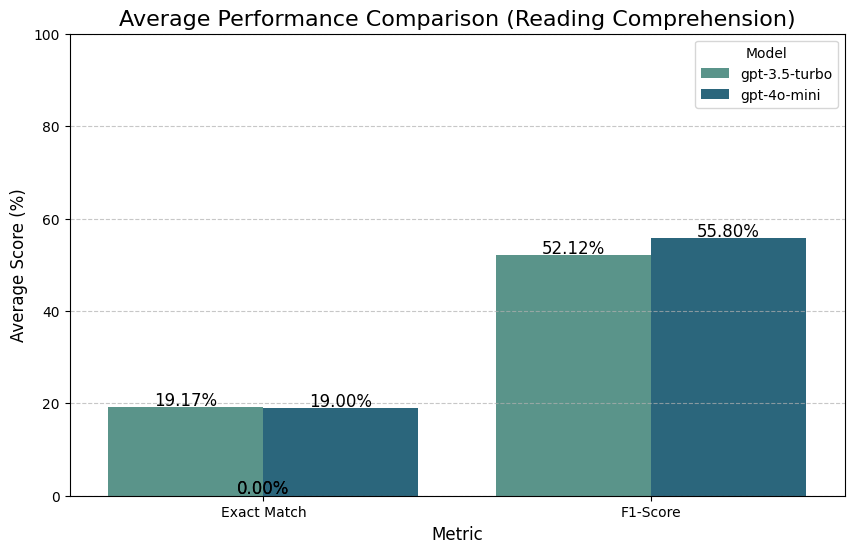

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rc_data = {
    'Experiment': [
        'English Prompt (Zero-shot)', 'Persian Prompt (Zero-shot)',
        'English Prompt (1-shot)', 'Persian Prompt (1-shot)',
        'English Prompt (3-shot)', 'Persian Prompt (3-shot)'
    ] * 2,
    'Model': [
        'gpt-3.5-turbo'] * 6 + ['gpt-4o-mini'] * 6,
    'Exact Match': [
        # gpt-3.5-turbo scores
        22.00, 5.50, 24.00, 18.00, 26.00, 19.50,
        # gpt-4o-mini scores
        13.00, 8.00, 24.00, 19.00, 26.00, 24.00
    ],
    'F1-Score': [
        # gpt-3.5-turbo scores
        56.13, 40.32, 56.07, 50.76, 57.36, 52.11,
        # gpt-4o-mini scores
        50.23, 45.54, 60.59, 56.12, 61.97, 60.37
    ]
}

df_rc = pd.DataFrame(rc_data)

print("\n\n📈=============== BIỂU ĐỒ SO SÁNH HIỆU SUẤT TRUNG BÌNH (READING COMPREHENSION) ===============📈")

# Nhóm theo model và tính điểm trung bình
df_summary = df_rc.groupby('Model')[['Exact Match', 'F1-Score']].mean().reset_index()

# Chuẩn bị dữ liệu để vẽ
df_summary_melted = df_summary.melt(id_vars='Model', var_name='Metric', value_name='Average Score')

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Average Score', hue='Model', data=df_summary_melted, palette='crest')

# Tùy chỉnh biểu đồ
plt.title('Average Performance Comparison (Reading Comprehension)', fontsize=16)
plt.ylabel('Average Score (%)', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị giá trị trên mỗi cột
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                       textcoords='offset points')

plt.show()

In [11]:
# Hiển thị bảng tóm tắt chi tiết
print("\n\n📊=============== BẢNG TÓM TẮT HIỆU SUẤT CHI TIẾT (READING COMPREHENSION) ===============📊")
# Sắp xếp lại DataFrame theo thứ tự mong muốn
prompt_order = [
    'English Prompt (Zero-shot)', 'Persian Prompt (Zero-shot)',
    'English Prompt (1-shot)', 'Persian Prompt (1-shot)',
    'English Prompt (3-shot)', 'Persian Prompt (3-shot)'
]
df_rc['Experiment'] = pd.Categorical(df_rc['Experiment'], categories=prompt_order, ordered=True)
df_rc = df_rc.sort_values('Experiment')

# Tạo bảng pivot
pivot_detailed = df_rc.pivot_table(index='Experiment', columns='Model', values=['Exact Match', 'F1-Score'])
print(pivot_detailed.to_markdown(floatfmt=".2f"))



📊=============== BẢNG TÓM TẮT HIỆU SUẤT CHI TIẾT (READING COMPREHENSION) ===============📊
| Experiment                 |   ('Exact Match', 'gpt-3.5-turbo') |   ('Exact Match', 'gpt-4o-mini') |   ('F1-Score', 'gpt-3.5-turbo') |   ('F1-Score', 'gpt-4o-mini') |
|:---------------------------|-----------------------------------:|---------------------------------:|--------------------------------:|------------------------------:|
| English Prompt (Zero-shot) |                              22.00 |                            13.00 |                           56.13 |                         50.23 |
| Persian Prompt (Zero-shot) |                               5.50 |                             8.00 |                           40.32 |                         45.54 |
| English Prompt (1-shot)    |                              24.00 |                            24.00 |                           56.07 |                         60.59 |
| Persian Prompt (1-shot)    |                              18.

C:\Users\GiaHyTran\AppData\Local\Temp\ipykernel_6584\439187645.py:13: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_detailed = df_rc.pivot_table(index='Experiment', columns='Model', values=['Exact Match', 'F1-Score'])
